In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import missingno as msno
import seaborn as sns
sns.set(style="whitegrid")

# Exploratory Data Analysis
## Missing Values

In [4]:
data = pd.read_csv('allStylesData.csv')
print(data.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107818 entries, 0 to 107817
Columns: 69 entries, recipeURL to notes
dtypes: float64(24), object(45)
memory usage: 56.8+ MB
None


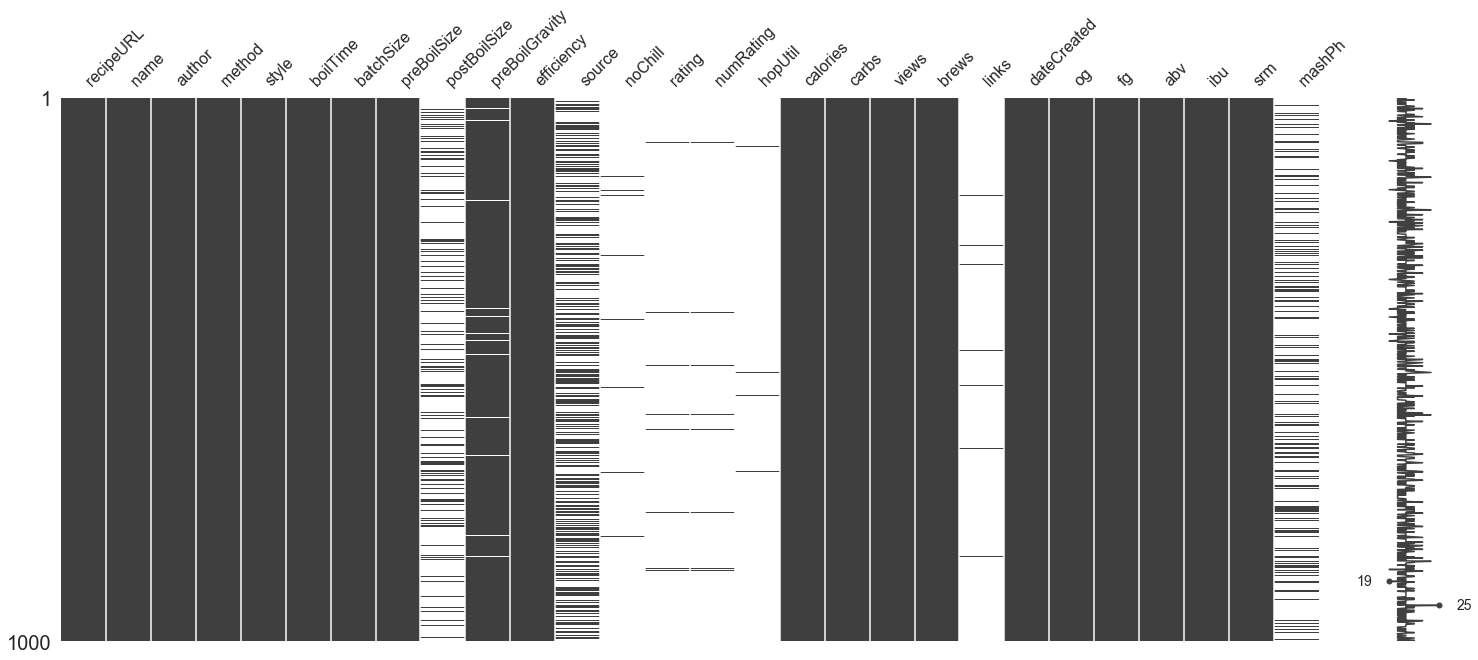

In [11]:
%matplotlib inline
msno.matrix(data.iloc[:,0:28].sample(1000))

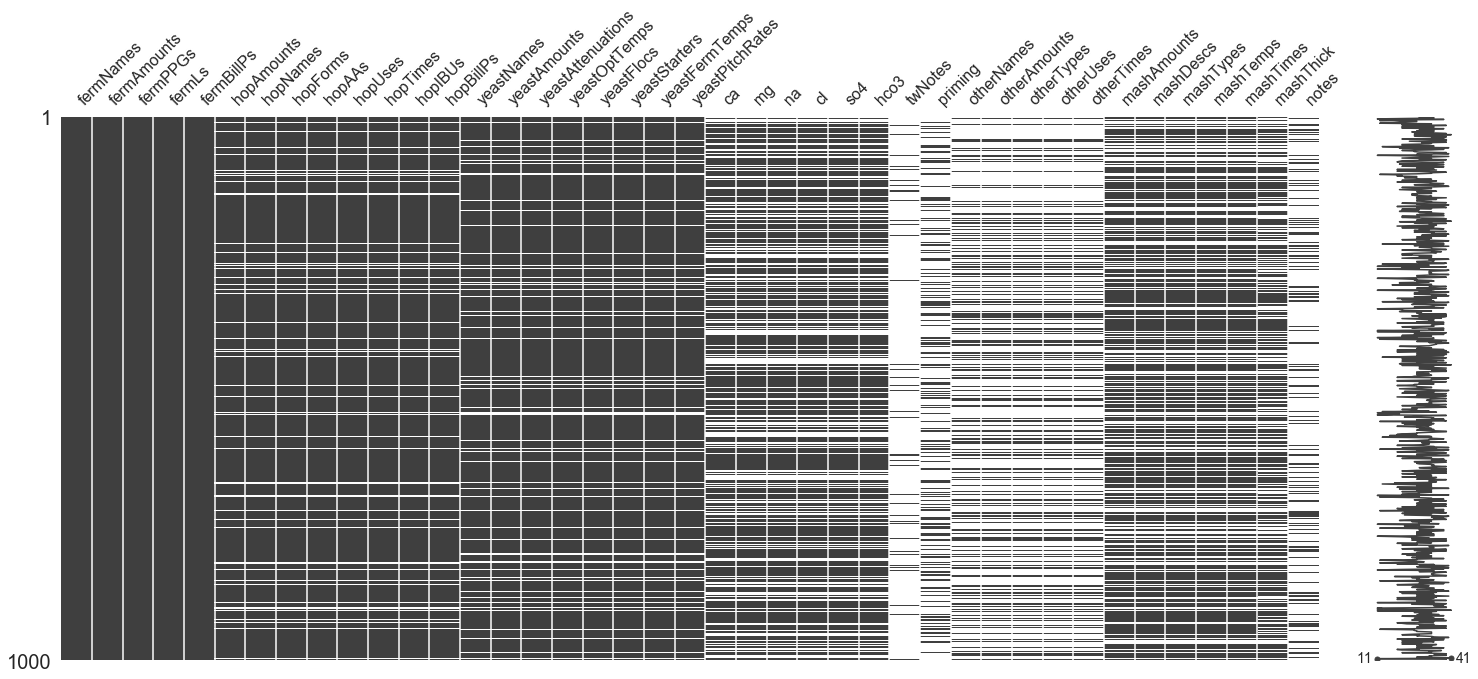

In [12]:
%matplotlib inline
msno.matrix(data.iloc[:,28:len(data.columns)].sample(1000))

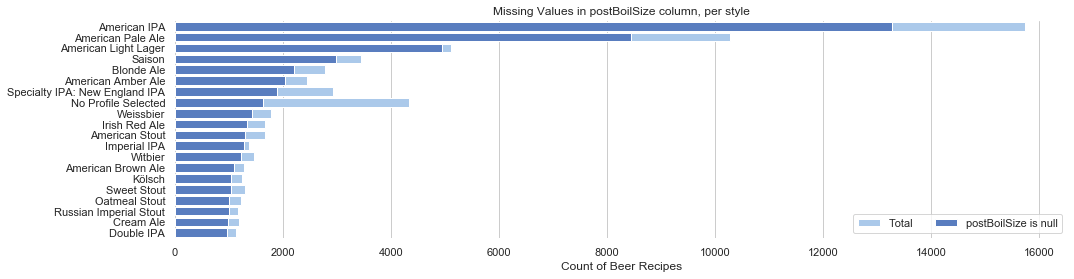

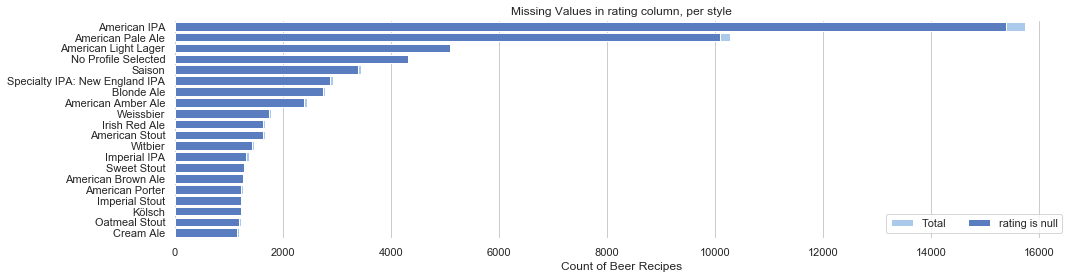

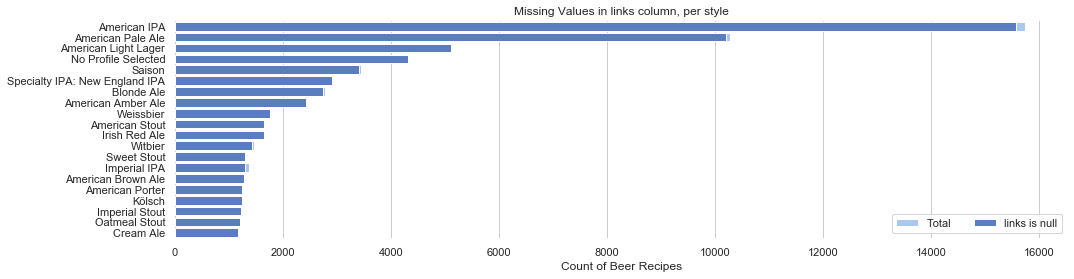

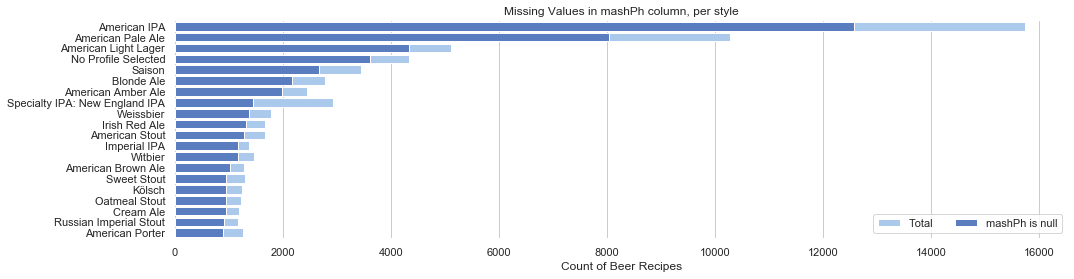

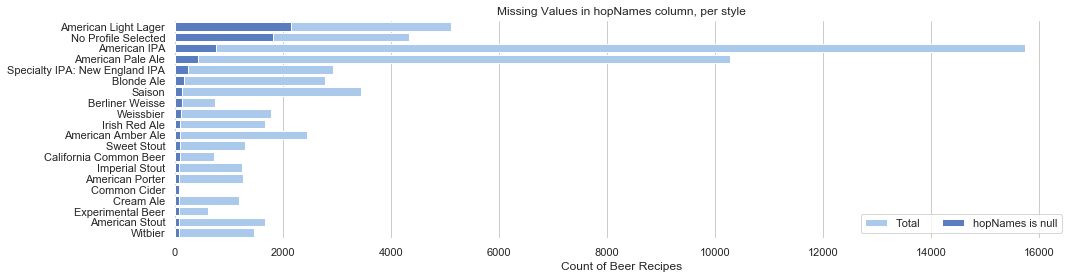

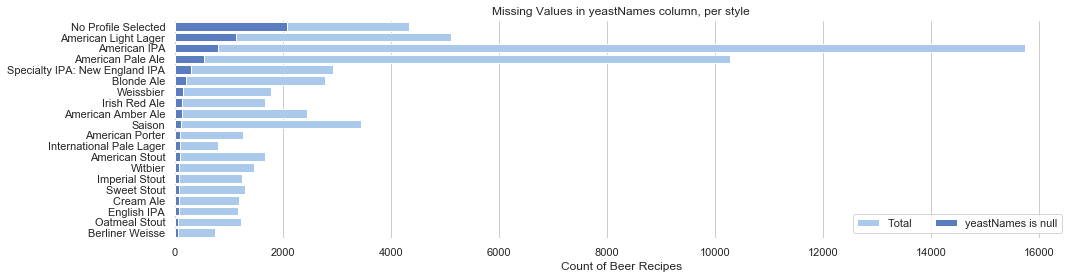

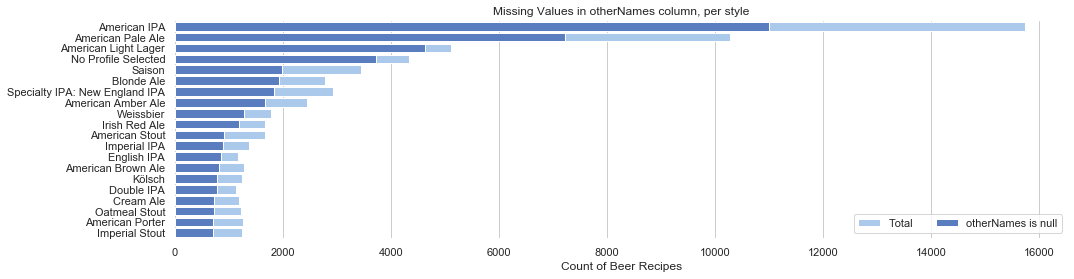

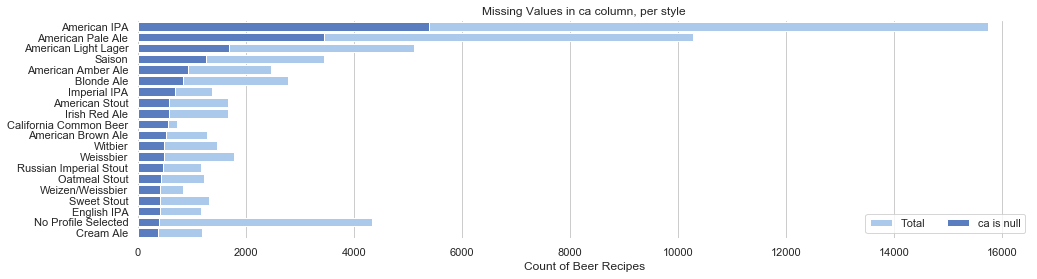

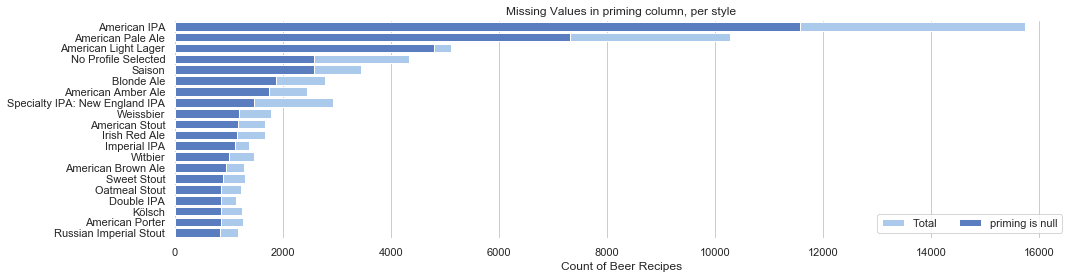

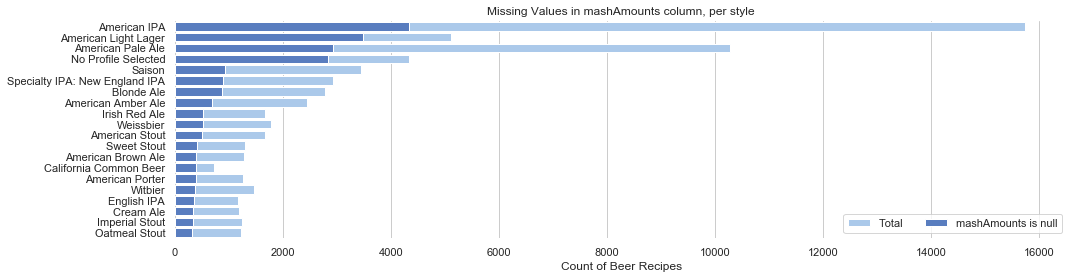

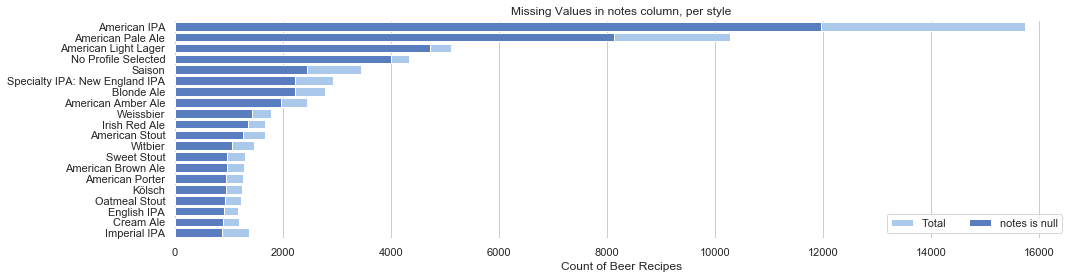

In [17]:
def stacked_bar_plot(column_of_interest):
    style_cnt = data.loc[:,['style',column_of_interest]]
    style_cnt['null'+column_of_interest] = style_cnt[column_of_interest].isnull()
    style_cnt['count'] = 1
    style_cnt_grp = style_cnt.loc[:,['style','count','null'+column_of_interest]].groupby('style').sum()

    style_cnt_grp = style_cnt_grp.sort_values('null'+column_of_interest, ascending=False)
    style_cnt_grp.reset_index(inplace=True)
    
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 4))
    
    # Plot the total
    x_total = 'count'
    y = 'style'
    sns.set_color_codes("pastel")
    sns.barplot(x=x_total, y=y, data=style_cnt_grp[:20], label="Total", color="b")

    # Plot
    x_sub_total = 'null'+column_of_interest
    sub_total_label = column_of_interest+' is null'
    sns.set_color_codes("muted")
    sns.barplot(x=x_sub_total, y=y, data=style_cnt_grp[:20], label=sub_total_label, color="b")
    
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    sns.despine(left=True, bottom=True)
    
    ax.set(title='Missing Values in '+column_of_interest+' column, per style', ylabel='', xlabel='Count of Beer Recipes')
    sns.despine(left=True, bottom=True)
    
    return #f, ax
    

stacked_bar_plot('postBoilSize')
stacked_bar_plot('rating')
stacked_bar_plot('links')
stacked_bar_plot('mashPh')
stacked_bar_plot('hopNames')
stacked_bar_plot('yeastNames')
stacked_bar_plot('otherNames')
stacked_bar_plot('ca')
stacked_bar_plot('priming')
stacked_bar_plot('mashAmounts')
stacked_bar_plot('notes')


## Style

                             style  count
0                     American IPA  15739
1                American Pale Ale  10275
2             American Light Lager   5119
3              No Profile Selected   4331
4                           Saison   3447
5   Specialty IPA: New England IPA   2922
6                       Blonde Ale   2784
7               American Amber Ale   2456
8                        Weissbier   1774
9                    Irish Red Ale   1674
10                  American Stout   1668
11                         Witbier   1469
12                    Imperial IPA   1368
13                     Sweet Stout   1310
14              American Brown Ale   1288
15                 American Porter   1255
16                          Kölsch   1252
17                  Imperial Stout   1247
18                   Oatmeal Stout   1224
19                       Cream Ale   1190


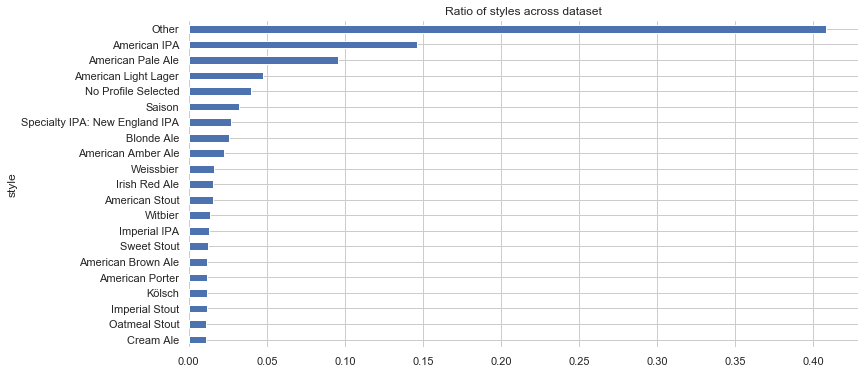

In [25]:
# Get top 20 styles
style_cnt = data.loc[:,['style']]
style_cnt['count'] = 1
style_cnt_grp = style_cnt.loc[:,['style','count']].groupby('style').sum()

style_cnt_grp = style_cnt_grp.sort_values('count', ascending=False)
style_cnt_grp.reset_index(inplace=True)
print(style_cnt_grp[0:20])

top20_styles = list(style_cnt_grp['style'][:20].values)
# style_cnts = data['style'].value_counts()
# style_cnts[0:20]

# Group by current count information computed earlier and group every style not in top20 together
style_cnt_other = style_cnt_grp.loc[:, ['style','count']]
style_cnt_other.style = style_cnt_grp['style'].apply(lambda x: x if x in top20_styles else 'Other')
style_cnt_other = style_cnt_other.groupby('style').sum()

# Get ratio of each style
style_cnt_other['ratio'] = style_cnt_other['count'].apply(lambda x: x/float(len(data)))
style_cnt_other = style_cnt_other.sort_values('count', ascending=False)

style_cnt_other['ratio'].plot(kind='barh', figsize=(12,6),)
plt.title('Ratio of styles across dataset')
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()

## Ingredients

In [9]:
def get_ingr_counts(ingrSeries, ingrName):
    #get list of ingredients used (contains repeats)
    ingrList = []
    #ingrSeries = ingrSeries.fillna('NA')

    #for each recipe, turn string of all ingredients into a list and add it to list of all fermentables used
    #this method assumes that each ingredient is only present once in each recipe
    for i in range(0,len(ingrSeries)):
        test_string = ingrSeries[i]
        tempType = re.findall(r'\'(.*?)\'', test_string)
        resType = list(map(str, tempType))    
        ingrList.append(resType)

    #create comprehensive list of unique hops used
    uniqueIngr = []
    for ingrs in ingrList:
        for ingr in ingrs:    
            if ingr not in uniqueIngr:
                uniqueIngr.append(ingr)

    print('Number of unique',ingrName,': ', len(uniqueIngr)) 

    #find number of recipes that each unique grain is used in.
    uniqueIngrCount = [0]*len(uniqueIngr)

    for i in range(0,len(ingrList)):
        for j in range(0,len(set(ingrList[i]))): #use set() to get set of hops for each recipe i.e set([1,1,2,2,3]) = [1,2,3]
            if ingrList[i][j] in uniqueIngr:
                uniqueIngrCount[uniqueIngr.index(ingrList[i][j])] = uniqueIngrCount[uniqueIngr.index(ingrList[i][j])]+1

    ingrPercentage = [x / len(ingrSeries) for x in uniqueIngrCount]            

    ingr_df = pd.DataFrame({ingrName:uniqueIngr,'Count':uniqueIngrCount, 'Percentage':ingrPercentage})
    ingr_df = ingr_df.sort_values('Count',ascending = False).reset_index(drop=True)
    
    return ingr_df

In [27]:
hopCount = get_ingr_counts(data.hopNames, 'Hops')
fermCount = get_ingr_counts(data.fermNames, 'Fermentables')
otherCount = get_ingr_counts(data.otherNames, 'Others')
dfCount = pd.concat([hopCount,fermCount,otherCount],axis=1)
dfCount[0:15]

Number of unique Hops :  4551
Number of unique Fermentables :  5472
Number of unique Others :  11350


,Hops,Count,Percentage,Fermentables,Count,Percentage,Others,Count,Percentage
0,Cascade,18211.0,0.168905,American - Pale 2-Row,32028.0,0.297056,Gypsum,7990,0.074106
1,Citra,14765.0,0.136944,United Kingdom - Maris Otter Pale,17983.0,0.166790,Whirlfloc,4911,0.045549
2,Centennial,11419.0,0.105910,Flaked Oats,15681.0,0.145440,Irish Moss,4279,0.039687
3,Amarillo,10418.0,0.096626,German - Pilsner,12263.0,0.113738,Calcium Chloride,3501,0.032471
4,Magnum,10199.0,0.094595,American - Carapils (Dextrine Malt),9897.0,0.091794,Lactic acid,2721,0.025237
5,Simcoe,8687.0,0.080571,American - Caramel / Crystal 60L,8603.0,0.079792,Calcium Chloride (dihydrate),2642,0.024504
6,Chinook,8479.0,0.078642,American - Pilsner,7972.0,0.073939,Epsom Salt,2641,0.024495
7,Columbus,8385.0,0.077770,American - Chocolate,7663.0,0.071073,Yeast Nutrient,1944,0.018030
8,East Kent Goldings,8013.0,0.074320,American - Caramel / Crystal 40L,7436.0,0.068968,Table Salt,1780,0.016509
9,Mosaic,7992.0,0.074125,German - Munich Light,6498.0,0.060268,irish moss,1332,0.012354


In [10]:
#by forcing all characters to lowercase, we can reduce the number of unique ingredients significantly,
#849 less for hops, 291 less for ferms, and 2221 less for others
hops = [str(hopList).lower() for hopList in data.hopNames]
ferms = [str(fermList).lower() for fermList in data.fermNames]
others = [str(otherList).lower() for otherList in data.otherNames]

hopCount = get_ingr_counts(hops, 'Hops')
fermCount = get_ingr_counts(ferms, 'Fermentables')
otherCount = get_ingr_counts(others, 'Others')
dfCount = pd.concat([hopCount,fermCount,otherCount],axis=1)
dfCount[0:15]

Number of unique Hops :  3702
Number of unique Fermentables :  5181
Number of unique Others :  9129


,Hops,Count,Percentage,Fermentables,Count,Percentage,Others,Count,Percentage
0,cascade,18332.0,0.170027,american - pale 2-row,32028.0,0.297056,gypsum,8307,0.077047
1,citra,14890.0,0.138103,united kingdom - maris otter pale,17986.0,0.166818,irish moss,6762,0.062717
2,centennial,11425.0,0.105966,flaked oats,15682.0,0.145449,whirlfloc,5696,0.052830
3,amarillo,10426.0,0.096700,german - pilsner,12263.0,0.113738,calcium chloride,3633,0.033696
4,magnum,10347.0,0.095967,american - carapils (dextrine malt),9897.0,0.091794,yeast nutrient,3268,0.030310
5,simcoe,8736.0,0.081025,american - caramel / crystal 60l,8603.0,0.079792,lactic acid,2873,0.026647
6,chinook,8517.0,0.078994,american - pilsner,7972.0,0.073939,epsom salt,2665,0.024718
7,columbus,8429.0,0.078178,american - chocolate,7663.0,0.071073,calcium chloride (dihydrate),2641,0.024495
8,mosaic,8040.0,0.074570,american - caramel / crystal 40l,7436.0,0.068968,table salt,1811,0.016797
9,east kent goldings,8015.0,0.074338,german - munich light,6498.0,0.060268,baking soda,1236,0.011464


In [20]:
#lets try using levenshtein distance to further reduce total number of unique ingredients
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from difflib import get_close_matches
  
possibleMatches = []
finalPossibleMatches = []
for i in range(0,len(hopCount.Hops)):
    possibleMatches.append(get_close_matches(hopCount.Hops[i],hopCount.Hops[i:],n=50,cutoff=0.85))
    if len(possibleMatches[i]) > 1:
        finalPossibleMatches.append(possibleMatches[i])


print('Total Possible Matches: ' + str(len(finalPossibleMatches)))          
print(finalPossibleMatches[0:10])            

Total Possible Matches: 1211
[['cascade', 'casscade', 'cascades', 'cascadee', 'casacade', 'cadscade', 'cascad', 'casade', 'cacade', 'cascadeca', 'cascade l', 'cascade 7', 'cascade 6', '2-cascade', 'cascada', 'casacde', 'cadcade', 'cacsade', 'caacade'], ['citra', 'cuitra', 'citra?', 'cirtra', 'ciitra', 'ctra', 'citr', 'cita', 'cira'], ['centennial', 'centennial.', 'centenial', 'centennial,,', '2-centennial', '1-centennial', 'centinnial', 'centential', 'centenniel', 'centeniall', 'cenntenial', 'us centennial', 'nb centennial'], ['amarillo', 'armarillo', 'ammarillo', 'amarillo®', 'amarilloo', 'amrillo', 'amarllo', 'amarilo', 'amarill', 'amaillo', 'amarilloam', 'amarillo1.', 'amarillo x', '2-amarillo', '1-amarillo', 'amrilllo', 'amerillo', 'amaril'], ['magnum', 'mangnum', 'magnum1', 'magnu'], ['simcoe', 'simecoe', 'simcoe®', 'simcoea', 'simco', 'simce', 'simcoe l', '2-simcoe'], ['chinook', 'chinoonk', 'chinook.', 'chinnook', 'chinoo', 'chinok', 'chinnok'], ['columbus', 'columbuss', 'columb

In [19]:
finalPossibleMatches

[['centennial', 'centennial.'],
 ['east kent goldings', 'east kent  goldings'],
 ['northern brewer',
  'northern brewers',
  'northern  brewer',
  'norther brewer',
  'northen brewer'],
 ['hallertau mittelfruh',
  'hhallertau mittelfruh',
  'halltertau mittelfruh',
  'hallertau mittelfruih',
  'hallertau mittelfrueh',
  'hallertau mittelfuh',
  'hallertau mittelfru',
  'hallertau mittefruh',
  'hallertauer mittelfruh',
  'hellertau mittelfruh',
  'hallertau mittlefruh',
  'hallertau mittelfuhr',
  'hallertau mittelfrüh'],
 ['hallertau hersbrucker',
  'harllertau hersbrucker',
  'hallertau hersbrucker0',
  'halertau hersbrucker',
  'hallertauer hersbrucker',
  'hallertau hersbrucher',
  'hallertau hersbruck'],
 ['styrian goldings', 'styrian goldins', 'styrian golding'],
 ['challenger', 'challenger9'],
 ['nelson sauvin', 'nelson  sauvin', 'nelson savin'],
 ['mandarina bavaria',
  'manndarina bavaria',
  'mandarinia bavaria',
  'mandarina bravaria',
  'mandarina bavarian',
  'mandarina ba

## Numerical Features

In [12]:
data.columns

Index(['recipeURL', 'name', 'author', 'method', 'style', 'boilTime',
       'batchSize', 'preBoilSize', 'postBoilSize', 'preBoilGravity',
       'efficiency', 'source', 'noChill', 'rating', 'numRating', 'hopUtil',
       'calories', 'carbs', 'views', 'brews', 'links', 'dateCreated', 'og',
       'fg', 'abv', 'ibu', 'srm', 'mashPh', 'fermNames', 'fermAmounts',
       'fermPPGs', 'fermLs', 'fermBillPs', 'hopAmounts', 'hopNames',
       'hopForms', 'hopAAs', 'hopUses', 'hopTimes', 'hopIBUs', 'hopBillPs',
       'yeastNames', 'yeastAmounts', 'yeastAttenuations', 'yeastOptTemps',
       'yeastFlocs', 'yeastStarters', 'yeastFermTemps', 'yeastPitchRates',
       'ca', 'mg', 'na', 'cl', 'so4', 'hco3', 'twNotes', 'priming',
       'otherNames', 'otherAmounts', 'otherTypes', 'otherUses', 'otherTimes',
       'mashAmounts', 'mashDescs', 'mashTypes', 'mashTemps', 'mashTimes',
       'mashThick', 'notes'],
      dtype='object')

In [8]:
# data[['og','fg','preBoilGravity','efficiency',
#       'calories','carbs','brews','numRating',
#       'abv','ibu','srm','mashPh','rating',
#       'views','boilTime','batchSize','preBoilSize',
#       'postBoilSize']] = data[['og','fg','preBoilGravity','efficiency','calories',
#                                'carbs','brews','numRating','abv','ibu','srm','mashPh',
#                                'rating','views','boilTime','batchSize','preBoilSize',
#                                'postBoilSize']].apply(pd.to_numeric) 

numericalFeatures = data.drop(columns=['recipeURL','name','author','method','style','source','noChill','links',
                                       'dateCreated','fermNames','fermAmounts','fermPPGs','fermLs','fermBillPs',
                                       'hopAmounts','hopNames','hopForms','hopAAs','hopUses','hopTimes','hopIBUs',
                                       'hopBillPs','yeastNames','yeastAmounts','yeastAttenuations', 'yeastOptTemps',
                                       'yeastFlocs', 'yeastStarters', 'yeastFermTemps', 'yeastPitchRates',
                                       'ca', 'mg', 'na', 'cl', 'so4', 'hco3', 'twNotes', 'priming','otherNames', 
                                       'otherAmounts', 'otherTypes', 'otherUses', 'otherTimes','mashAmounts',
                                       'mashDescs', 'mashTypes', 'mashTemps', 'mashTimes','mashThick', 'notes'])

numericalFeatures = numericalFeatures.round(3)
numericalFeatures.head()

,boilTime,batchSize,preBoilSize,postBoilSize,preBoilGravity,efficiency,rating,numRating,hopUtil,calories,carbs,views,brews,og,fg,abv,ibu,srm,mashPh
0,90.0,6.60,7.66,NaN,1.055,74.0,4.33,3.0,NaN,211.0,20.0,"148,952",29.0,1.064,1.013,6.76,64.26,7.78,5.65
1,90.0,5.50,7.50,NaN,1.033,70.0,NaN,NaN,NaN,150.0,15.0,"147,517",25.0,1.046,1.010,4.61,22.81,12.56,NaN
2,60.0,5.00,7.50,NaN,1.038,56.0,NaN,NaN,NaN,185.0,19.0,853,1.0,1.056,1.014,5.50,109.81,25.33,NaN
3,90.0,6.25,7.50,NaN,1.045,70.0,NaN,NaN,NaN,179.0,20.0,852,0.0,1.054,1.016,4.92,44.46,13.15,NaN
4,90.0,6.34,8.98,NaN,1.032,88.0,NaN,NaN,NaN,150.0,14.0,848,2.0,1.046,1.009,4.89,28.08,12.02,NaN


In [9]:
numericalFeatures.describe().T

,count,mean,std,min,25%,50%,75%,max
boilTime,107818.0,65.678198,14.935558,1.000,60.000,60.000,60.0000,240.000
batchSize,107818.0,20.430469,79.677946,0.130,5.280,5.500,7.9300,3100.000
preBoilSize,107818.0,22.700690,84.003058,0.130,6.600,7.500,9.2500,4000.000
postBoilSize,20264.0,25.325404,90.559501,0.100,5.280,6.000,8.5000,2602.540
preBoilGravity,105590.0,1.049636,0.028024,0.994,1.039,1.046,1.0540,1.507
efficiency,107818.0,71.084930,8.527834,0.000,70.000,70.000,75.0000,100.000
rating,2067.0,4.470024,0.822945,1.000,4.000,5.000,5.0000,5.000
numRating,2067.0,1.198839,1.467175,1.000,1.000,1.000,1.0000,25.000
calories,107818.0,197.095828,966.335077,-315994.000,164.000,187.000,222.0000,3548.000
carbs,107818.0,18.927174,241.192737,-79138.000,16.000,19.000,22.0000,202.000


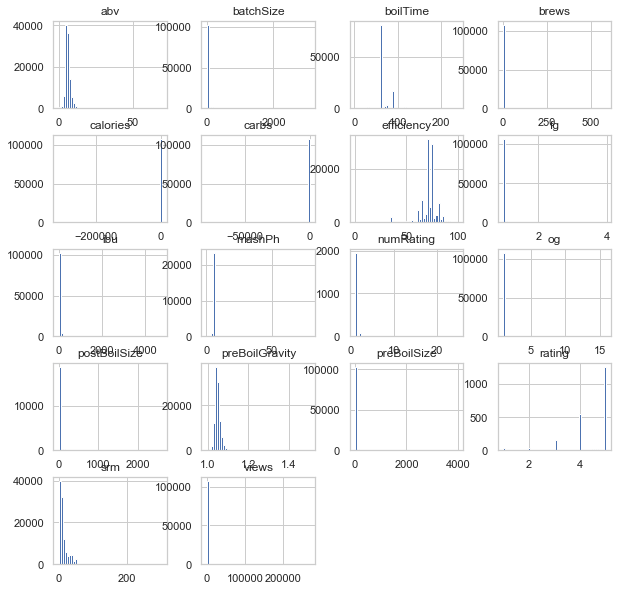

In [74]:
hist = numericalFeatures.hist(bins=50,figsize =(10,10))